In [2]:
import pandas as pd
import numpy as np

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

from astropy import units as u
from astropy import coordinates as coord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.utils.data import get_pkg_data_filename

from urllib.request import urlretrieve

import math

## Define parameters

In [3]:
E_max_parameter = 5e15 * u.eV

savePlots = False
showPlots = True

## Define the following functions
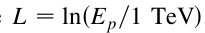

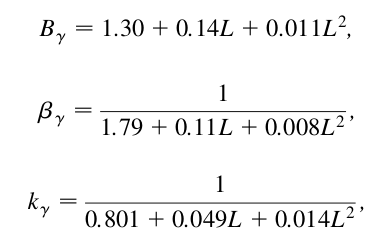

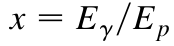

In [4]:
@u.quantity_input(E_proton=u.eV)
def L(E_proton):
  return (np.log(E_proton/u.TeV)).decompose()

@u.quantity_input(E_proton=u.eV)
def BGamma(E_proton):
  return (1.3 + 0.14*L(E_proton) + 0.011*(L(E_proton))**2).decompose()

@u.quantity_input(E_proton=u.eV)
def BetaGamma(E_proton):
  return (1/(1.79 + 0.11*L(E_proton) + 0.008*(L(E_proton))**2)).decompose()

@u.quantity_input(E_proton=u.eV)
def KGamma(E_proton):
  return (1/(0.801 + 0.049*L(E_proton) + 0.014*(L(E_proton))**2)).decompose()

@u.quantity_input(E_proton=u.eV, E_gamma=u.eV)
def x(E_proton, E_gamma):
  return (E_gamma/E_proton).decompose()

## Define the production rate of gamma rays
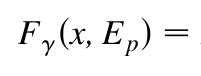

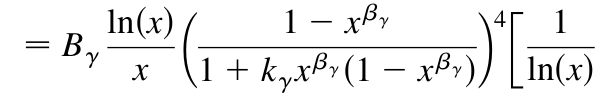
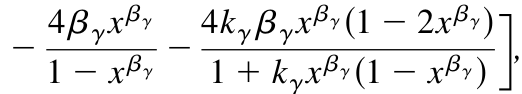

In [5]:
# BE CAREFUL (E_gamma cannot equal E_proton because a divide by zero error)
@u.quantity_input(E_proton=u.eV, E_gamma=u.eV)
def gammaRayProductionRate(E_proton, E_gamma):
  xToBetaGamma = (x(E_proton, E_gamma))**BetaGamma(E_proton)

  first_part = BGamma(E_proton) * np.log(x(E_proton, E_gamma))/x(E_proton, E_gamma)
  second_part = ((1-xToBetaGamma) / (1+ KGamma(E_proton)*xToBetaGamma*(1-xToBetaGamma)))**4
  third_part = 1/np.log(x(E_proton, E_gamma)) - (4*BetaGamma(E_proton)*xToBetaGamma)/(1 - xToBetaGamma) - (4*KGamma(E_proton)*BetaGamma(E_proton)*xToBetaGamma * (1 - 2 * xToBetaGamma))/(1 + KGamma(E_proton) * xToBetaGamma * (1 - xToBetaGamma))

  return (first_part * second_part * third_part).decompose()

## Define the cross section
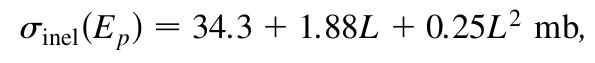

In [6]:
@u.quantity_input(E_proton=u.eV)
def CrossSection(E_proton):
  return (34.3 + 1.88*L(E_proton) + 0.25 * L(E_proton)**2) * u.mbarn

### The transport function (Aiden's code)
$$ f(E, R, t) = N_0 (\frac{E}{E_0})^{-\delta} \frac{1}{\pi^\frac32 R_{diff}^2} \exp \left(\frac{-(R - R_{sh})^2}{R_{diff}^2} \right) \frac{\sqrt{\pi} R_{diff}^2}{\sqrt{\pi} R_{diff}^2 + 4 R_{sh} R_{diff} + 2 R_{sh}^2 \sqrt{\pi} } $$
* `R` is the distance from the center of the supernova to the molecular cloud
* `R_diff` is the average random walk distance of the particle
$$ R_{diff} = \sqrt{4 D(E) t'} $$
* `D(E)` is the diffusion coefficient
$$ D(E) = [0.1, 0.5] \times 10^{28} \left( \frac{E}{10 GeV} \right)^{\frac12} \left( \frac{B}{3 \mu G} \right)^{-\frac12} cm^2 s^{-1} $$

* `T_esc` the time it takes to get from the center of the supernova to the shell
$$ t' = t - t_{esc} $$


In [7]:
@u.quantity_input(E = u.erg)
def dNdE(E, Emax = E_max_parameter, Emin=1*u.GeV, eta = 0.25, Esn = 1e52*u.erg, alpha = 1):
    dNdE = (eta*Esn*(-alpha+2))/(Emax**(2-alpha)-Emin**(2-alpha))*E**-alpha
    return dNdE

@u.quantity_input(t=u.yr, E=u.eV)
def Rshell(E, n0=10/u.cm**3, ESN=1e52*u.erg, Emax = E_max_parameter, beta = 2.48):
    R = 0.31*(ESN/(1e51*u.erg))**(1/5)*(n0/(u.cm**-3))**(-1/5)*(Tesc(E, Emax, beta)/u.yr)**(2/5) *u.pc
    return R.to(u.pc)

@u.quantity_input(t=u.yr, E=u.eV)
def Rshell_Tesc(t, n0=10/u.cm**3, ESN=1e52*u.erg, Emax = E_max_parameter, beta = 2.48):
    R = 0.31*(ESN/(1e51*u.erg))**(1/5)*(n0/(u.cm**-3))**(-1/5)*(t/u.yr)**(2/5) *u.pc
    return R.to(u.pc)

@u.quantity_input(E=u.erg)
def Tesc(E, Emax = E_max_parameter, beta = 2.48, ts = 1600*u.yr):
    return (ts*(E/Emax)**(-1/beta)).to(u.yr)

@u.quantity_input(E=u.erg)
def diffusion(E, B = 50 * u.uG, x = 0.1, delta = 0.5, Dn = 3e27 * 0.1):
    dif = x * Dn * ((3*E/(u.GeV))/(10*B/(u.uG)))**delta
    return dif * u.cm**2 * u.s**-1

@u.quantity_input(E=u.erg, R=u.pc, t=u.yr)
def transport_function(E, R, t, alpha = 2.7):
    Rdif = 2 * np.sqrt(diffusion(E) * (t - Tesc(E)))

    first1 = (np.pi**(1/2))*(Rdif**2) 
    first2 = 2*(np.pi**(1/2)*(Rshell(E))**2) 
    first3 = 4*Rshell(E)*(Rdif)
    
    firstT = first1 + first2 + first3

    dist = dNdE(E)*(firstT/(np.pi**(1/2)*(Rdif)**2))**(-1)*(1/(np.pi**(3/2)*(Rdif)**3))*np.exp(-(R-Rshell(E))**2/(Rdif)**2)
    return dist.to(1/(u.TeV * u.cm**3))

## Define the integrand function
$$ \sigma_{inel}(E_p) \times f(E_p, R, t) \times F(x, E_p) \times \frac{1}{E_p} \ $$

In [8]:
def integrand_function(E_proton, E_gamma, time_parameter, radial_distance_parameter):
  return (CrossSection(E_proton) * transport_function(E_proton, radial_distance_parameter, time_parameter) * gammaRayProductionRate(E_proton, E_gamma) / E_proton).to(u.eV**-2 * u.m**-1)

## Calculate the term 
$$ \int_{E_\gamma}^\infty \left[ \sigma_{inel}(E_p) \times f(E_p, R, t) \times F(x, E_p) \times \frac{1}{E_p} \right] dE_p \ $$

In [9]:
# For memoization
memo = {}

In [10]:
def integrateForEGamma(E_gamma, time_parameter, radial_distance_parameter):
  # Numerical integral
  E_proton_logspace = np.logspace(np.log10((E_gamma.value)), np.log10(E_max_parameter.value), num=1000)
  
  # Preallocate the result array with the same length as E_proton_logspace
  result_array = np.zeros_like(E_proton_logspace) * u.eV**(-1) * u.m**(-1)

  # Convert E_proton_logspace to astropy units in a vectorized manner
  E_proton_arr = E_proton_logspace * u.eV

  # Apply the integrand function in a vectorized manner to all proton energies
  result_array = integrand_function(E_proton_arr, E_gamma, time_parameter, radial_distance_parameter)

  E_diff = np.diff(E_proton_arr)

  return np.sum(E_diff * result_array[1:])

def calcIntegralForRangeOfE_gamma(E_min, time_parameter, radial_distance_parameter):
  key = E_min.to_string() + time_parameter.to_string() + radial_distance_parameter.to_string()
  if key in memo:
    return memo[key]["E_gamma_logspace"], memo[key]["final_result_array"]
  # Works rn but fix in the future pls 
  E_min = E_min.to(u.eV)
  E_gamma_logspace = np.logspace(np.log10(E_min.value), np.log10(E_max_parameter.value), num=500) * u.eV
  final_result_array = np.zeros_like(E_gamma_logspace) * u.eV**(-1) * u.m**(-1) / u.eV
  # E_gamma_logspace = E_gamma_logspace * u.eV

  for i, E_gamma in enumerate(E_gamma_logspace):
    final_result_array[i] = integrateForEGamma(E_gamma, time_parameter, radial_distance_parameter)
  
  memo[key] = {"E_gamma_logspace": E_gamma_logspace, "final_result_array": final_result_array}
  return memo[key]["E_gamma_logspace"], memo[key]["final_result_array"]
  # return E_gamma_logspace, final_result_array

## Constructing the final function for gamma ray production
$$ \frac{dN_\gamma}{dE_p}(E_\gamma) = \frac{c n_p V}{4 \pi d^2} \int_{E_\gamma}^\infty \left[ \sigma_{inel}(E_p) \times f(E_p, R, t) \times F(x, E_p) \times \frac{1}{E_p} \right] dE_p $$

In [97]:
light_speed = 3e8 * u.m / u.s

@u.quantity_input(E_gamma=u.eV, time_parameter=u.yr, radial_distance_parameter=u.pc, n_p=1/u.m**3, cloud_volume=u.m**3, dist_to_earth=u.pc)
def calcRateOfChangeOfRaysNumberWithRespectToEnergy(E_gamma, time_parameter, radial_distance_parameter, n_p=7200/u.m**3, cloud_volume=904.7*u.pc**3, dist_to_earth=20_000*u.pc):
  E_gamma_logspace, results_range = calcIntegralForRangeOfE_gamma(E_gamma, time_parameter, radial_distance_parameter)
  return E_gamma_logspace, (light_speed * n_p * cloud_volume / (4*np.pi*dist_to_earth**2)) * results_range

## Plotting function
Takes in the x- and y-axis, and the time passed since the supernova explosion

In [104]:
def plotGammaProductionRate(E_gamma_logspace, result_arr, time_parameter, radial_distance_parameter, mode, label="t", showInfo=True, plottingMethod="scatter", scaleBy=None, parameter_value=None, precision=2):
  index = 0
  for i in result_arr:
    if not math.isnan(i.value):
      break
    index += 1
  # print(index, "data points out of [full] are NaN")


  flux_arr = (E_gamma_logspace**2 * result_arr).to(u.TeV / u.cm**2 / u.s)
  E_gamma_logspace = E_gamma_logspace.to(u.TeV)

  max_index = np.nanargmax(flux_arr)
  max_E_flux = flux_arr[max_index]
  max_E_gamma = E_gamma_logspace[max_index]
  
  globalRatio = 1.0
  if scaleBy != None:
    ratio = (scaleBy/max_E_flux).value
    # if ratio > 1:
    #   ratio = math.floor(ratio)
    globalRatio = ratio
    flux_arr *= ratio
  
  globalRatio = globalRatio * u.eV / u.eV

  # plt.figure()

  if plottingMethod == "scatter":
    method = plt.scatter
  elif plottingMethod == "plot":
    method = plt.plot

  labels = []

  if label == "t":
    if showInfo:
      labels.append(f"R = {radial_distance_parameter.to_string(format='latex')}")
    method(E_gamma_logspace, flux_arr, label=f"t = {time_parameter.to(u.kyr).to_string(format='latex', precision=precision)}" + r", $R_{shell} = $" + f"{Rshell_Tesc(time_parameter).to_string(precision=1)}" + (f", • ( {globalRatio.to_string(format='latex', precision=1)})" if scaleBy != None else ""))
  elif label == "R":
    if showInfo:
      labels.append(f"Time = {time_parameter.to(u.kyr).to_string(format='latex', precision=precision)}")
      labels.append(r"$R_{shell}$" + f" = {Rshell_Tesc(time_parameter).to_string(precision=1)}")
    method(E_gamma_logspace, flux_arr, label=f"R = {radial_distance_parameter.to_string(format='latex')}" + (f", • ( {globalRatio.to_string(format='latex', precision=1)})" if scaleBy != None else ""))
  else:
    if showInfo:
      labels.append(f"R = {radial_distance_parameter.to_string(format='latex')}")
      labels.append(f"Time = {time_parameter.to(u.kyr).to_string(format='latex', precision=precision)}")
      labels.append(r"$R_{shell}$" + f" = {Rshell_Tesc(time_parameter).to_string(precision=1)}")
    method(E_gamma_logspace, flux_arr, label=f"{label} = {parameter_value.to_string(format='latex', precision=precision)}" + (f", • ( {globalRatio.to_string(format='latex', precision=1)})" if scaleBy != None else ""))

  
  if mode == "log":
    plt.xscale('log')
    plt.yscale('log')
  
  plt.xlabel(f"E_gamma ({E_gamma_logspace.unit})")
  plt.ylabel(r"$E^2 \times \frac{dN}{dE}$ " + f"({flux_arr.unit})" )

  return max_E_flux, labels
  
  # plt.show()


## Compute gamma production rate at different t-values

In [101]:
def computeGammaProductionRateTimeVariance(radial_distance_parameter=10*u.pc):
  time_variance_data = {
    "E_gamma_logspace_list": [],
    "result_arr_list": [],
    "time_parameter_list": [],
    "radial_distance_parameter": radial_distance_parameter
  }

  time_parameters = [10, 30, 50] * u.kyr

  for i in range(len(time_parameters)):
    time_parameter = time_parameters[i]
    E_gamma_logspace, result_arr = calcRateOfChangeOfRaysNumberWithRespectToEnergy(1 * u.GeV, time_parameter, time_variance_data["radial_distance_parameter"])
    
    time_variance_data["E_gamma_logspace_list"].append(E_gamma_logspace)
    time_variance_data["result_arr_list"].append(result_arr)
    time_variance_data["time_parameter_list"].append(time_parameter)
  
  return time_variance_data

In [14]:
import matplotlib.patches as mpl_patches
from matplotlib.lines import Line2D

def saveAndPlot(plt, saveID, customLabels=None):
  # Get current handles and labels
  handles, labels = plt.gca().get_legend_handles_labels()

  # Add a custom label (use a blank Line2D object with the desired label)
  custom_line = Line2D([0], [0], color='black', lw=2, linestyle='', label="Custom Label")

  handles.insert(0, custom_line)
  labels.insert(0, " ")
  # Add custom handle and label to the list
  if customLabels != None:
    for customLabel in customLabels:
      handles.insert(0, custom_line)
      labels.insert(0, customLabel)

  # Create the legend with all the handles and labels
  leg = plt.legend(handles=handles, labels=labels, frameon=False)

  bold = True
  for text in leg.get_texts():
    if text.get_text() == " ":
      bold = False

    if bold:
        text.set_fontsize('large')
        text.set_color('black')
    else:
        text.set_fontweight('normal')

  if saveID != None and savePlots == True:
    plt.savefig(saveID + '.png', bbox_inches='tight')
  plt.show()

## Plotting
* Plot all the production rates and investigate the differences

In [15]:
# Linear plot
def linearPlotTimeVariance(time_variance_data, saveID=None):
  plt.figure()
  for E_gamma_logspace, result_arr, time_parameter in zip(time_variance_data["E_gamma_logspace_list"], time_variance_data["result_arr_list"], time_variance_data["time_parameter_list"]):
    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, time_parameter, time_variance_data["radial_distance_parameter"], "linear", showInfo=True, plottingMethod="plot")
  saveAndPlot(plt, saveID, labels)

In [16]:
# Linear plot (scaled)
def linearPlotScaledTimeVariance(time_variance_data, saveID=None):
  index = 1
  biggest_max = None

  plt.figure()
  for E_gamma_logspace, result_arr, time_parameter in zip(time_variance_data["E_gamma_logspace_list"], time_variance_data["result_arr_list"], time_variance_data["time_parameter_list"]):

    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, time_parameter, time_variance_data["radial_distance_parameter"], "linear", showInfo=True, plottingMethod="plot", scaleBy=biggest_max)

    if index == 1:
      biggest_max = max_E_flux
    
    index += 1
  saveAndPlot(plt, saveID, labels)

In [17]:
# Log plot
def logPlotTimeVariance(time_variance_data, saveID=None):
  plt.figure()
  for E_gamma_logspace, result_arr, time_parameter in zip(time_variance_data["E_gamma_logspace_list"], time_variance_data["result_arr_list"], time_variance_data["time_parameter_list"]):
    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, time_parameter, time_variance_data["radial_distance_parameter"], "log", showInfo=True, plottingMethod="plot")
  saveAndPlot(plt, saveID, labels)

In [18]:
# Log plot (scaled)
def logPlotScaledTimeVariance(time_variance_data, saveID=None):
  index = 1
  biggest_max = None

  plt.figure()
  for E_gamma_logspace, result_arr, time_parameter in zip(time_variance_data["E_gamma_logspace_list"], time_variance_data["result_arr_list"], time_variance_data["time_parameter_list"]):
    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, time_parameter, time_variance_data["radial_distance_parameter"], "log", showInfo=True, plottingMethod="plot", scaleBy=biggest_max)

    if index == 1:
      biggest_max = max_E_flux
    
    index += 1
  saveAndPlot(plt, saveID, labels)

## Compute gamma production rate at different R-values

In [107]:
# R = radial_distance_parameter = Distance to the molecular cloud from the center of supernova
def computeGammaProductionRateRVariance(time_parameter=10_000 * u.yr):
  radial_variance_data = {
    "E_gamma_logspace_list": [],
    "result_arr_list": [],
    "radial_distance_parameter_list": [],
    "time_parameter": time_parameter
  }

  radial_distances_parameters = [30, 50, 100, 200] * u.pc

  for i in range(len(radial_distances_parameters)):
    radial_distance_parameter = radial_distances_parameters[i]
    E_gamma_logspace, result_arr = calcRateOfChangeOfRaysNumberWithRespectToEnergy(1 * u.GeV, radial_variance_data["time_parameter"], radial_distance_parameter)
    
    radial_variance_data["E_gamma_logspace_list"].append(E_gamma_logspace)
    radial_variance_data["result_arr_list"].append(result_arr)
    radial_variance_data["radial_distance_parameter_list"].append(radial_distance_parameter)

  return radial_variance_data

## Plotting
* Plot all the production rates and investigate the differences

In [20]:
# Linear plot
def linearPlotRVariance(radial_variance_data, saveID=None):
  plt.figure()
  for E_gamma_logspace, result_arr, radial_distance_parameter in zip(radial_variance_data["E_gamma_logspace_list"], radial_variance_data["result_arr_list"], radial_variance_data["radial_distance_parameter_list"]):
    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, radial_variance_data["time_parameter"], radial_distance_parameter, "linear", showInfo=True, label="R", plottingMethod="plot")
  saveAndPlot(plt, saveID, labels)

In [21]:
# Linear plot (scaled)
def linearPlotScaledRVariance(radial_variance_data, saveID=None):
  index = 1
  biggest_max = None

  plt.figure()
  for E_gamma_logspace, result_arr, radial_distance_parameter in zip(radial_variance_data["E_gamma_logspace_list"], radial_variance_data["result_arr_list"], radial_variance_data["radial_distance_parameter_list"]):

    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, radial_variance_data["time_parameter"], radial_distance_parameter, "linear", showInfo=True, label="R", plottingMethod="plot", scaleBy=biggest_max)

    if index == 1:
      biggest_max = max_E_flux
    
    index += 1
  saveAndPlot(plt, saveID, labels)

In [22]:
# Log plot
def logPlotRVariance(radial_variance_data, saveID=None):
  plt.figure()
  for E_gamma_logspace, result_arr, radial_distance_parameter in zip(radial_variance_data["E_gamma_logspace_list"], radial_variance_data["result_arr_list"], radial_variance_data["radial_distance_parameter_list"]):
    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, radial_variance_data["time_parameter"], radial_distance_parameter, "log", showInfo=True, label="R", plottingMethod="plot")
  saveAndPlot(plt, saveID, labels)

In [23]:
# Log plot (scaled)
def logPlotScaledRVariance(radial_variance_data, saveID=None):
  index = 1
  biggest_max = None

  plt.figure()
  for E_gamma_logspace, result_arr, radial_distance_parameter in zip(radial_variance_data["E_gamma_logspace_list"], radial_variance_data["result_arr_list"], radial_variance_data["radial_distance_parameter_list"]):
    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, radial_variance_data["time_parameter"], radial_distance_parameter, "log", showInfo=True, label="R", plottingMethod="plot", scaleBy=biggest_max)

    if index == 1:
      biggest_max = max_E_flux
    
    index += 1
  saveAndPlot(plt, saveID, labels)

## Compute and plot

In [102]:
timeVarianceComputations = []
timeVarianceComputations.append(computeGammaProductionRateTimeVariance(30*u.pc))
timeVarianceComputations.append(computeGammaProductionRateTimeVariance(50*u.pc))
timeVarianceComputations.append(computeGammaProductionRateTimeVariance(100*u.pc))
timeVarianceComputations.append(computeGammaProductionRateTimeVariance(200*u.pc))

/home/joe/anaconda3/envs/pracs/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/joe/anaconda3/envs/pracs/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/joe/anaconda3/envs/pracs/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [108]:
radialVarianceComputations = []
radialVarianceComputations.append(computeGammaProductionRateRVariance(10_000*u.yr))
radialVarianceComputations.append(computeGammaProductionRateRVariance(30_000*u.yr))
radialVarianceComputations.append(computeGammaProductionRateRVariance(50_000*u.yr))

/home/joe/anaconda3/envs/pracs/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/joe/anaconda3/envs/pracs/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/joe/anaconda3/envs/pracs/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


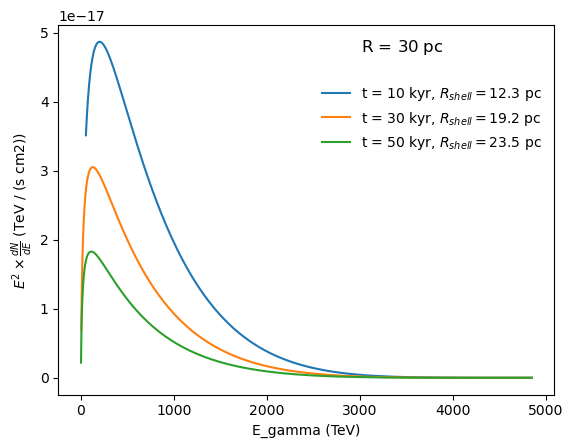

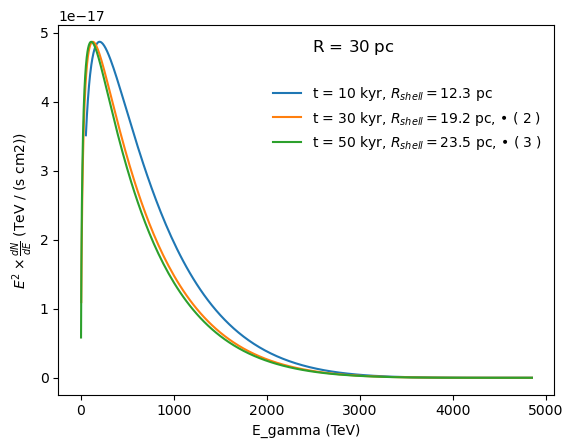

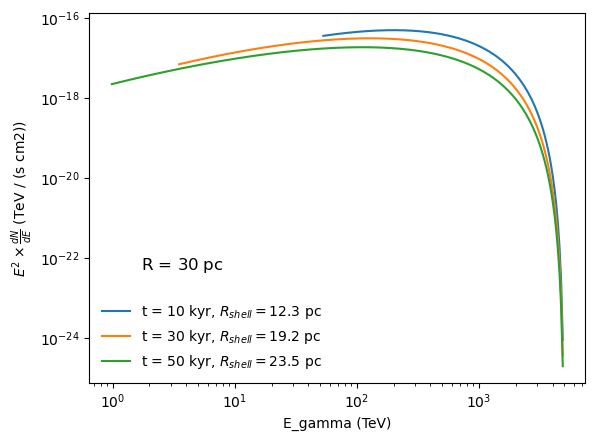

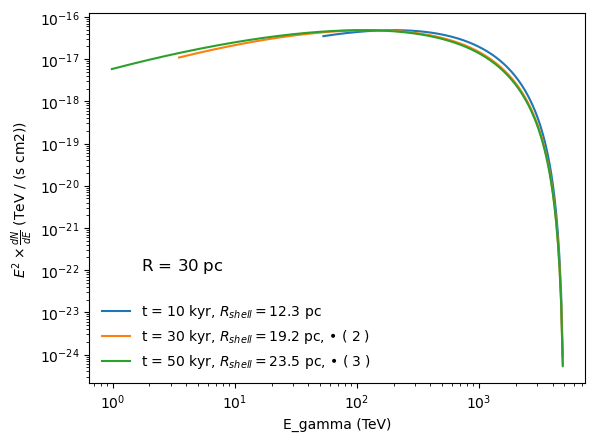

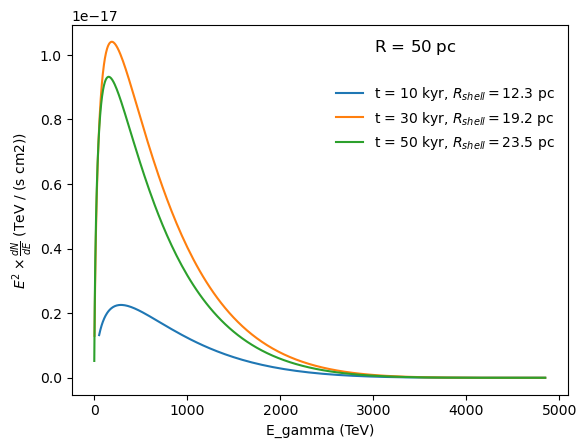

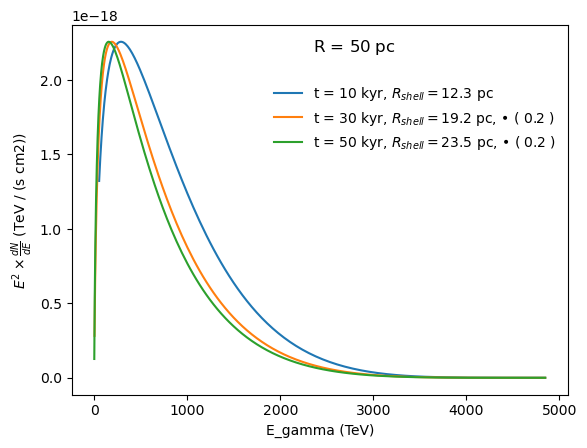

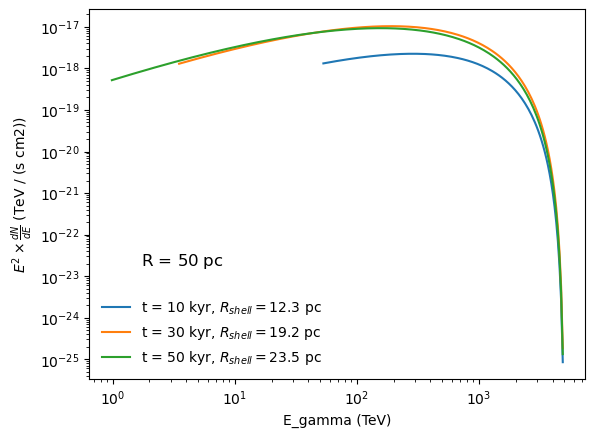

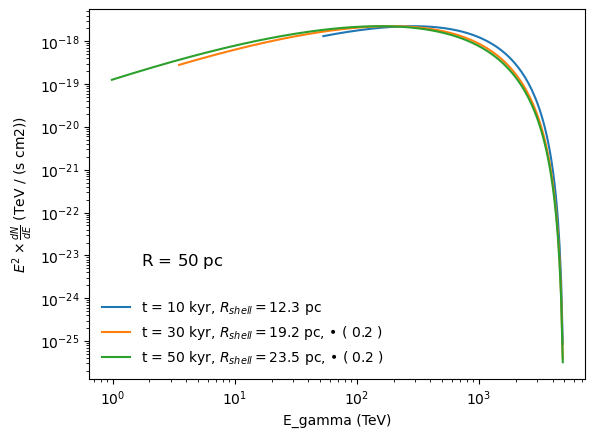

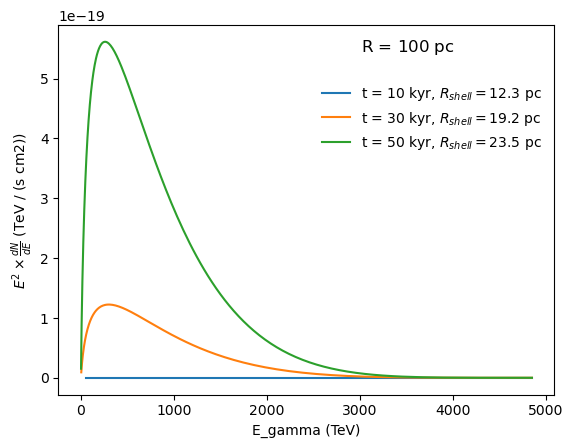

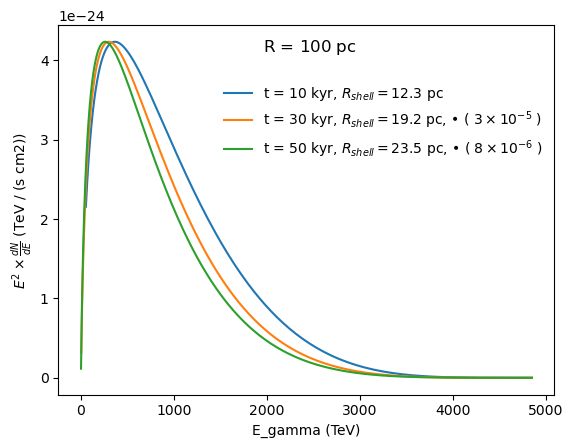

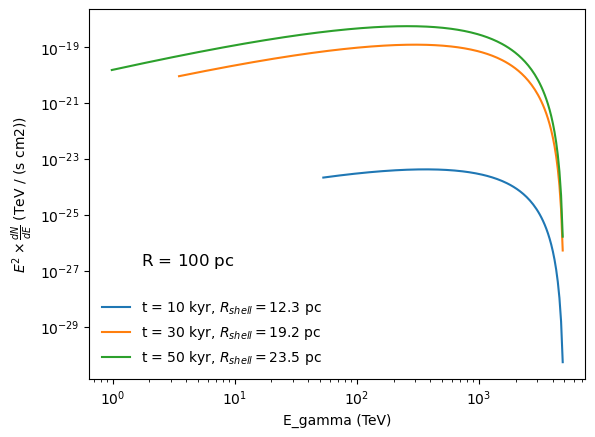

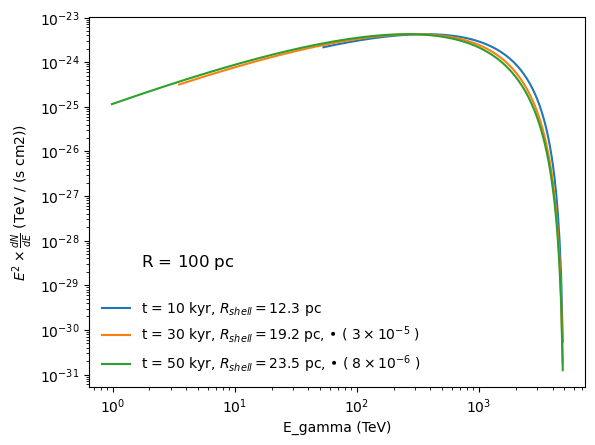

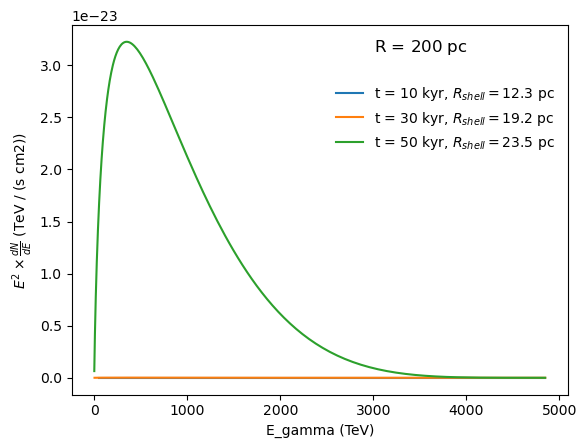

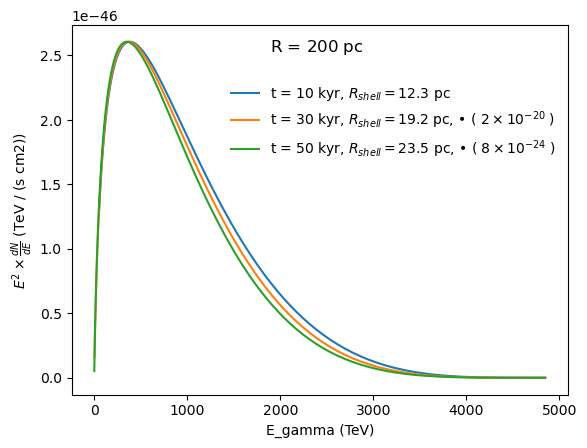

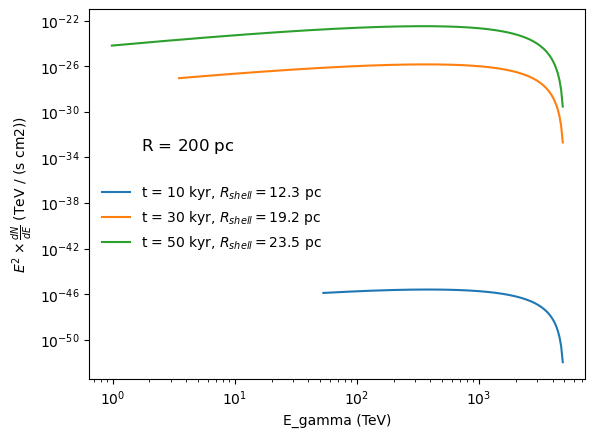

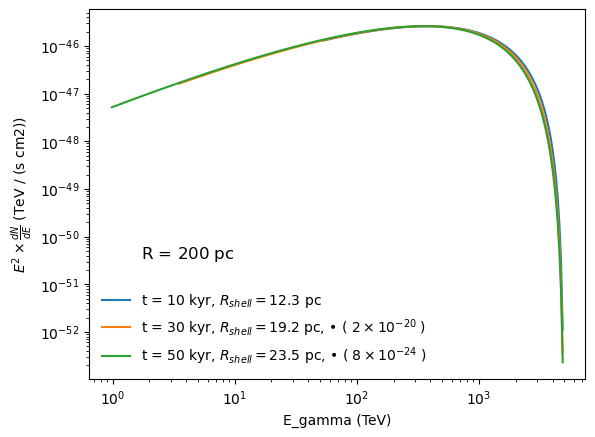

In [105]:
savePlots = True
for computation in timeVarianceComputations:
  first_part = 'gamma_production_plots/fixed_R/' + computation["radial_distance_parameter"].to_string().replace(" ", "_")
  linearPlotTimeVariance(computation, first_part + '_linear')
  linearPlotScaledTimeVariance(computation, first_part + '_linear_scaled')
  logPlotTimeVariance(computation, first_part + '_log')
  logPlotScaledTimeVariance(computation, first_part + '_log_scaled')

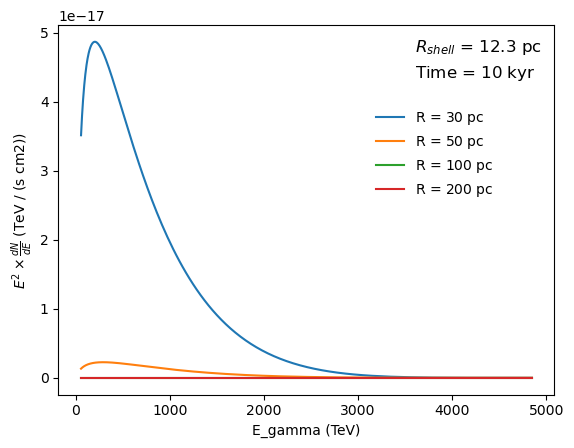

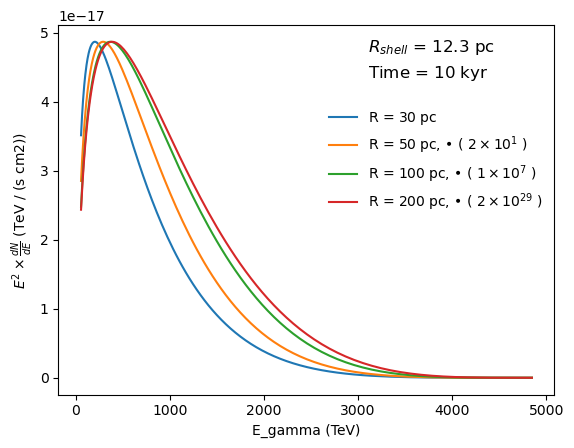

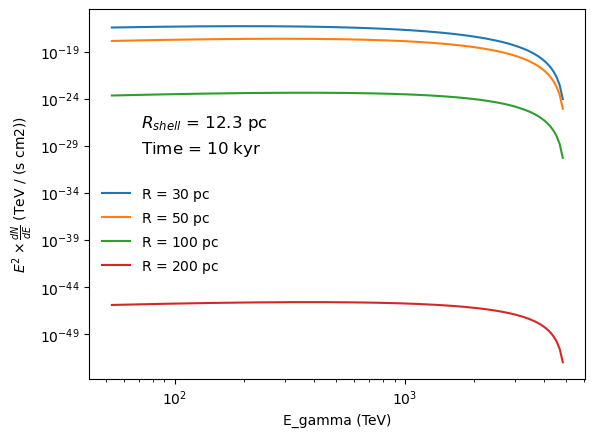

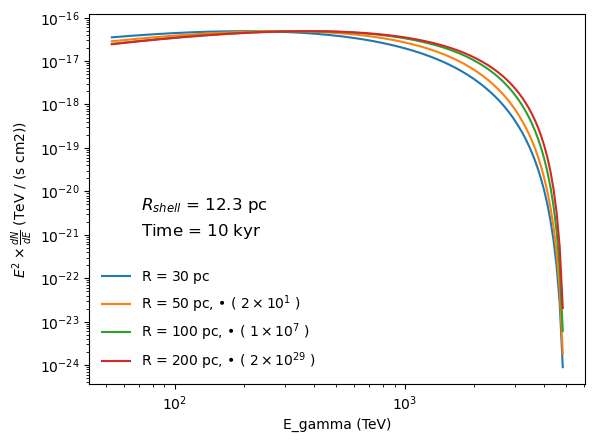

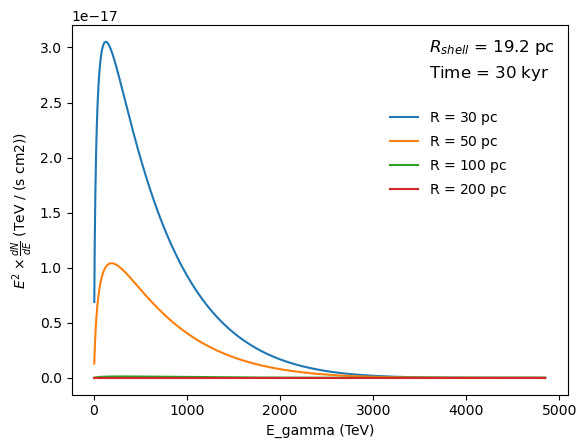

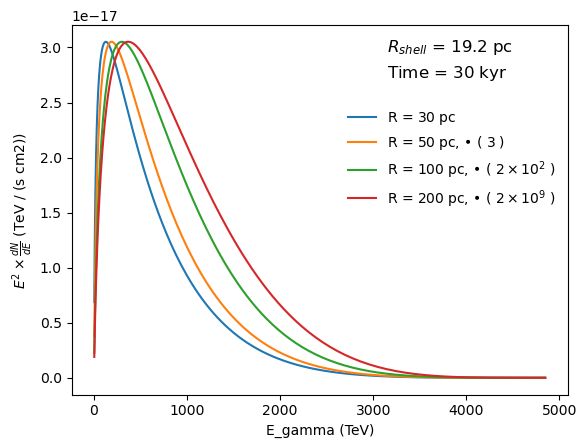

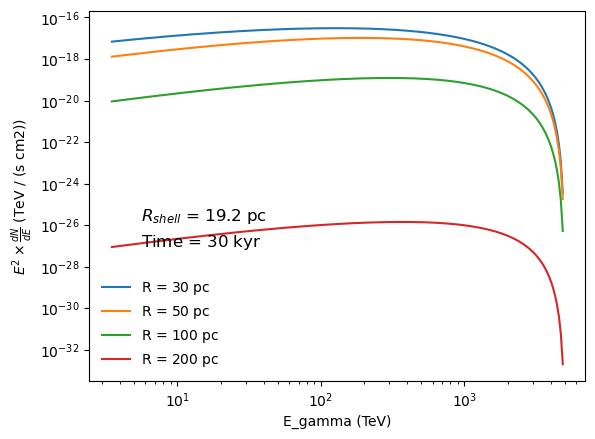

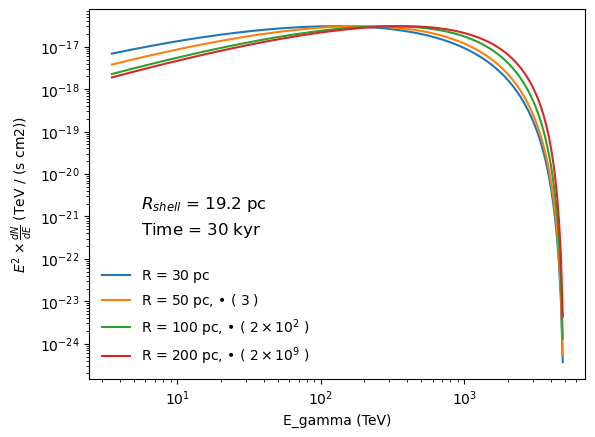

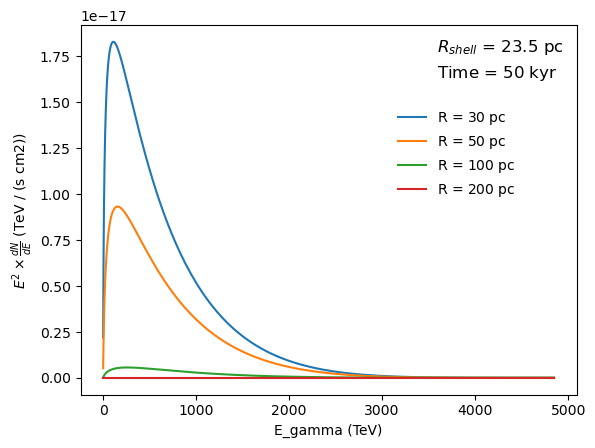

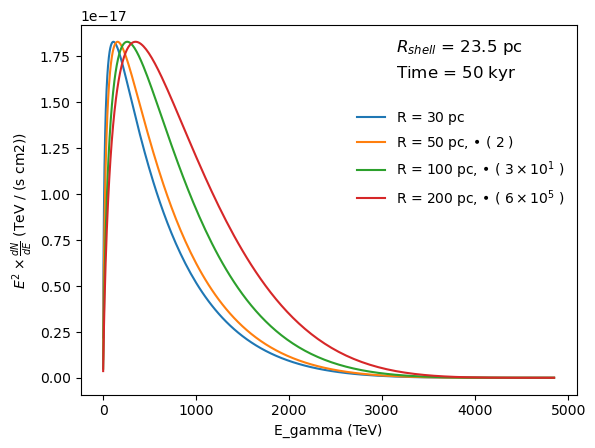

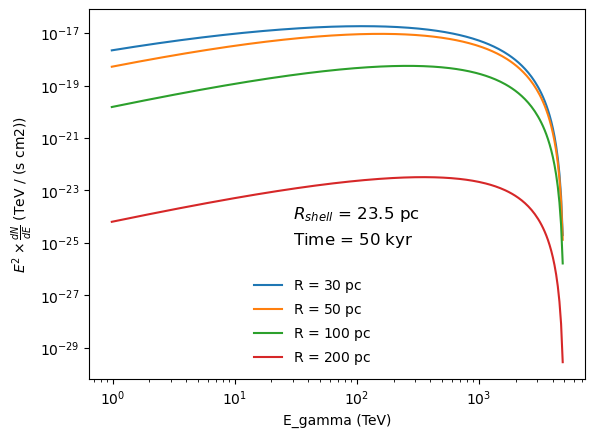

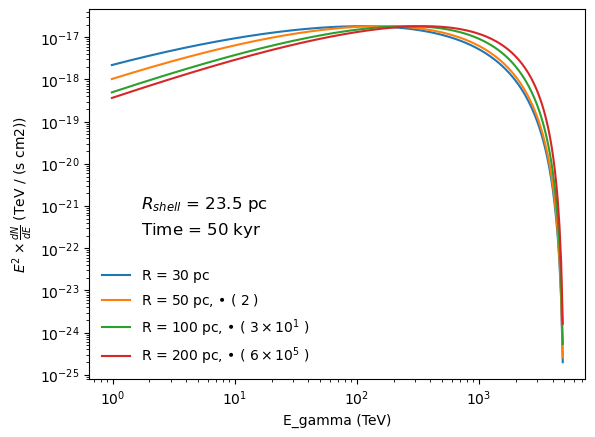

In [109]:
savePlots = True
for computation in radialVarianceComputations:
  first_part = 'gamma_production_plots/fixed_t/' + computation["time_parameter"].to_string().replace(" ", "_")
  linearPlotRVariance(computation, first_part + '_linear')
  linearPlotScaledRVariance(computation, first_part + '_linear_scaled')
  logPlotRVariance(computation, first_part + '_log')
  logPlotScaledRVariance(computation, first_part + '_log_scaled')

In [28]:
def computeGammaProductionRateParameterVariance(time_parameter, radial_distance_parameter, parameter_name, parameter_symbol, parameter_list):
  variance_data = {
    "E_gamma_logspace_list": [],
    "result_arr_list": [],
    "parameter_list": [],
    "time_parameter": time_parameter,
    "radial_distance_parameter": radial_distance_parameter,
    "parameter_name": parameter_name,
    "parameter_symbol": parameter_symbol,
  }

  for parameter in parameter_list:
    # parameter = parameter_list[i]
    E_gamma_logspace, result_arr = calcRateOfChangeOfRaysNumberWithRespectToEnergy(1 * u.GeV, variance_data["time_parameter"], variance_data["radial_distance_parameter"], **{variance_data["parameter_name"]: parameter})
    
    variance_data["E_gamma_logspace_list"].append(E_gamma_logspace)
    variance_data["result_arr_list"].append(result_arr)
    variance_data["parameter_list"].append(parameter)

  return variance_data

In [29]:
# Linear plot
def unscaledPlot(variance_data, saveID=None, mode="linear"):
  plt.figure()
  for E_gamma_logspace, result_arr, parameter in zip(variance_data["E_gamma_logspace_list"], variance_data["result_arr_list"], variance_data["parameter_list"]):
    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, variance_data["time_parameter"], variance_data["radial_distance_parameter"], mode, showInfo=True, label=variance_data["parameter_symbol"], plottingMethod="plot", parameter_value=parameter, precision=4)
  saveAndPlot(plt, saveID, labels)

In [30]:
def scaledPlot(variance_data, saveID=None, mode="linear"):
  index = 1
  biggest_max = None

  plt.figure()
  for E_gamma_logspace, result_arr, parameter in zip(variance_data["E_gamma_logspace_list"], variance_data["result_arr_list"], variance_data["parameter_list"]):
    max_E_flux, labels = plotGammaProductionRate(E_gamma_logspace, result_arr, variance_data["time_parameter"], variance_data["radial_distance_parameter"], mode, showInfo=True, label=variance_data["parameter_symbol"], plottingMethod="plot", parameter_value=parameter, scaleBy=biggest_max, precision=4)

    if index == 1:
      biggest_max = max_E_flux
    
    index += 1
  saveAndPlot(plt, saveID, labels)

In [31]:
def plotParameterVariance(varianceComputations, folderName, linear=True, linearScaled=True, log=True, logScaled=True):
  for computation in varianceComputations:
    first_part = 'gamma_production_plots/' + folderName + '/' + computation["time_parameter"].to_string().replace(" ", "_")  + computation["radial_distance_parameter"].to_string().replace(" ", "_")
    
    if linear:
      unscaledPlot(computation, first_part + '_linear', mode="linear")
    if linearScaled:
      scaledPlot(computation, first_part + '_linear_scaled', mode="linear")
    if log:
      unscaledPlot(computation, first_part + '_log', mode="log")
    if logScaled:
      scaledPlot(computation, first_part + '_log_scaled', mode="log")

In [32]:
def calcVolume(spread):
  return (4/3)*np.pi*(spread/2)**3
  
cloud_volume_parameter_list = [calcVolume(10), calcVolume(50), calcVolume(100), calcVolume(150)] * u.pc**3
args = {"parameter_name": "cloud_volume", "parameter_symbol": "V", "parameter_list": cloud_volume_parameter_list}

cloudVolumeVarianceComputations = []

cloudVolumeVarianceComputations.append(computeGammaProductionRateParameterVariance(4_000*u.yr, 30 * u.pc, **args))
cloudVolumeVarianceComputations.append(computeGammaProductionRateParameterVariance(20_000*u.yr, 30 * u.pc, **args))
cloudVolumeVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 30 * u.pc, **args))

cloudVolumeVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 50 * u.pc, **args))
cloudVolumeVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 100 * u.pc, **args))
cloudVolumeVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 200 * u.pc, **args))

In [33]:
# savePlots = True
# plotParameterVariance(cloudVolumeVarianceComputations, 'change_cloud_volume')

In [34]:
n_p_parameter_list = [100, 500, 1000] / u.cm**3
args = {"parameter_name": "n_p", "parameter_symbol": "n_p", "parameter_list": n_p_parameter_list}

protonNumberDensityVarianceComputations = []

protonNumberDensityVarianceComputations.append(computeGammaProductionRateParameterVariance(4_000*u.yr, 20 * u.pc, **args))
protonNumberDensityVarianceComputations.append(computeGammaProductionRateParameterVariance(20_000*u.yr, 20 * u.pc, **args))
protonNumberDensityVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 20 * u.pc, **args))

protonNumberDensityVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 50 * u.pc, **args))
protonNumberDensityVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 100 * u.pc, **args))
protonNumberDensityVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 200 * u.pc, **args))

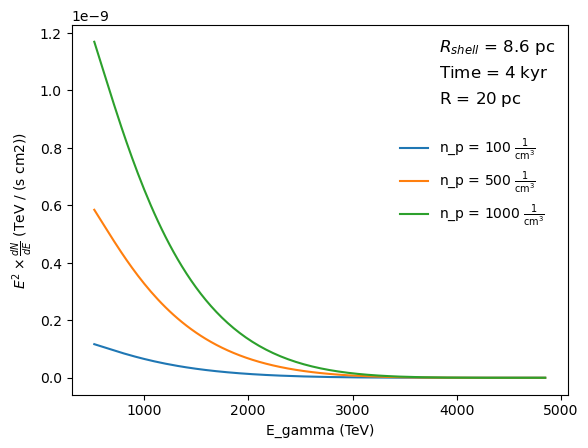

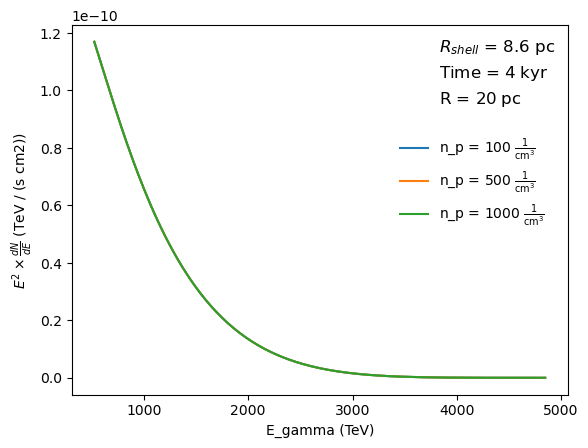

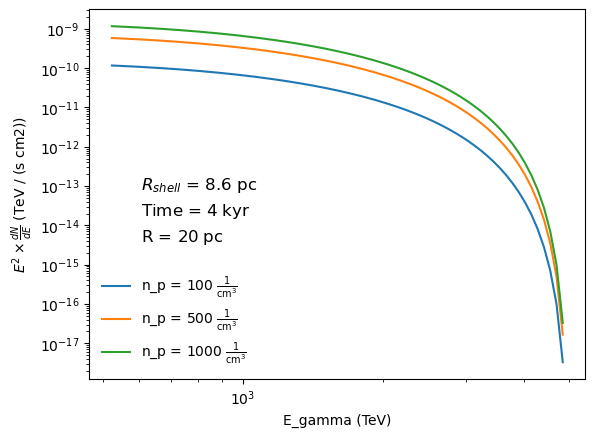

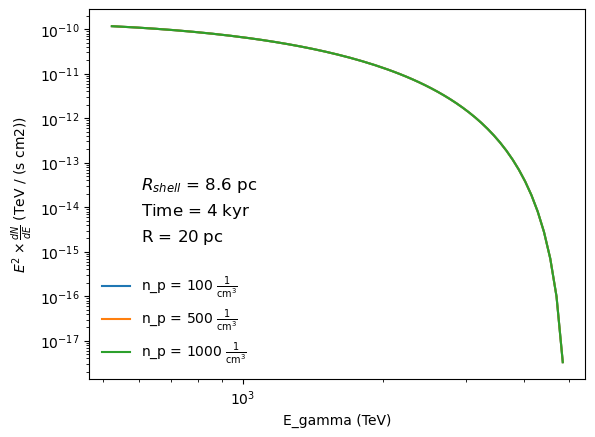

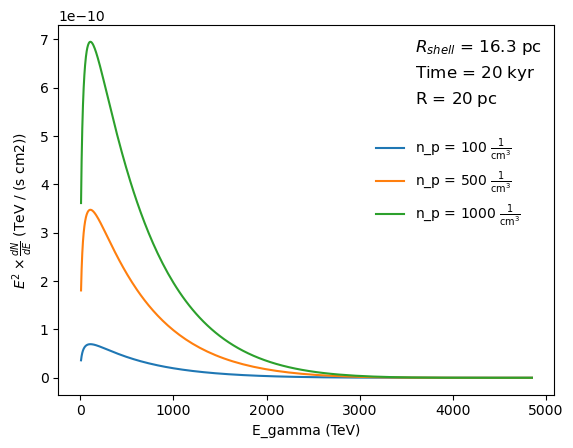

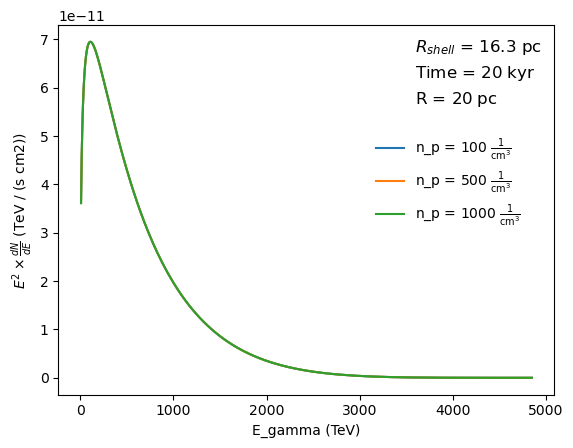

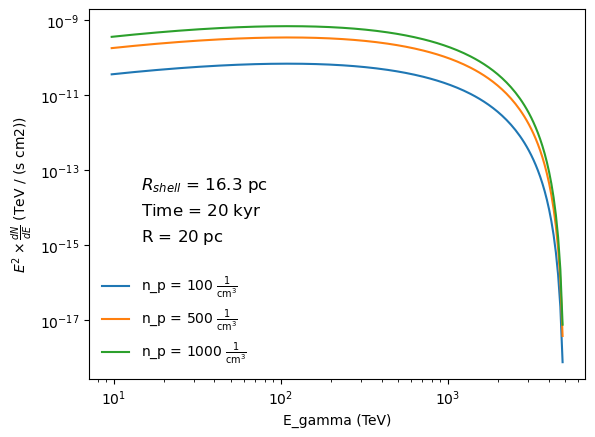

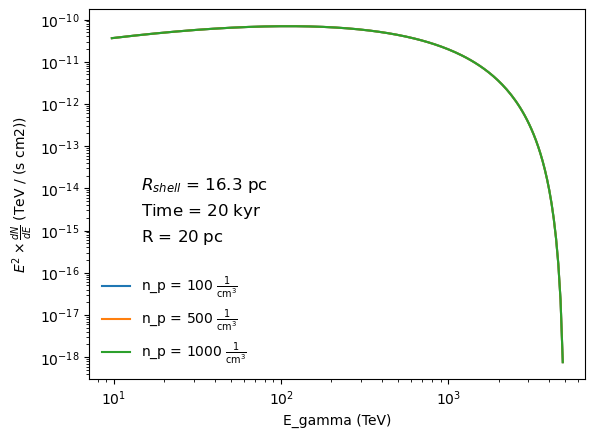

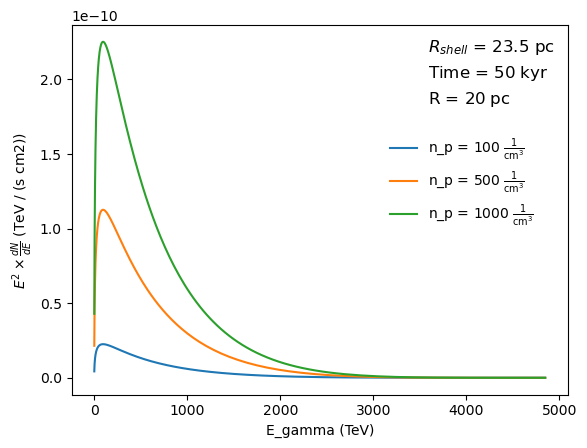

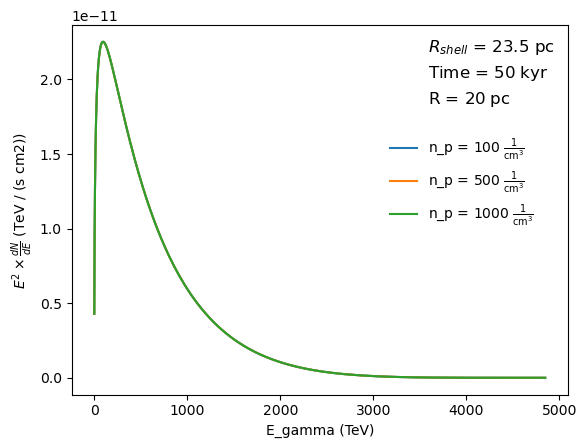

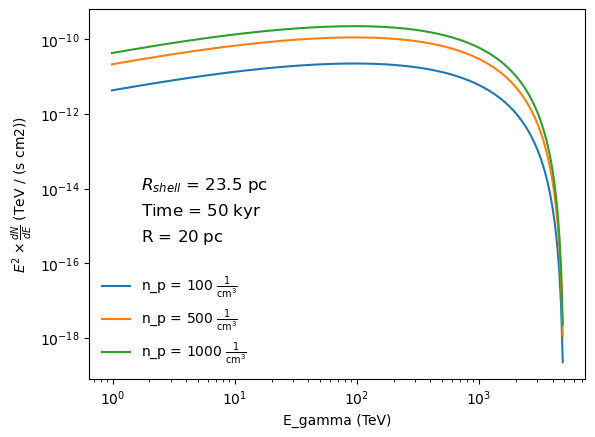

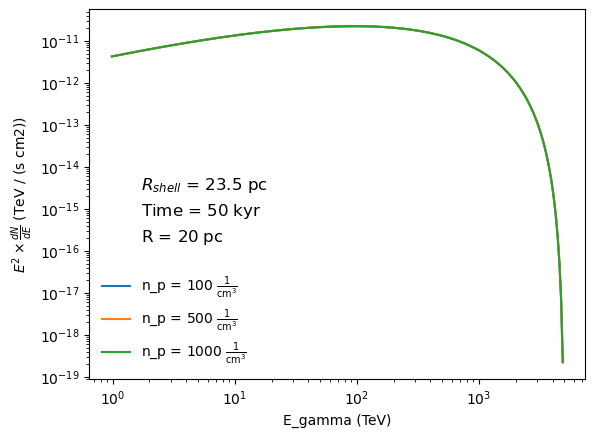

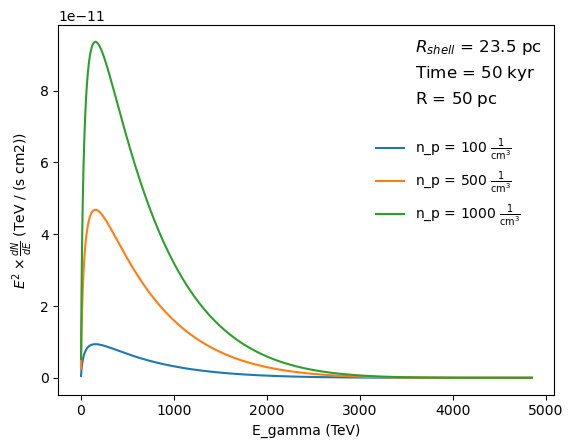

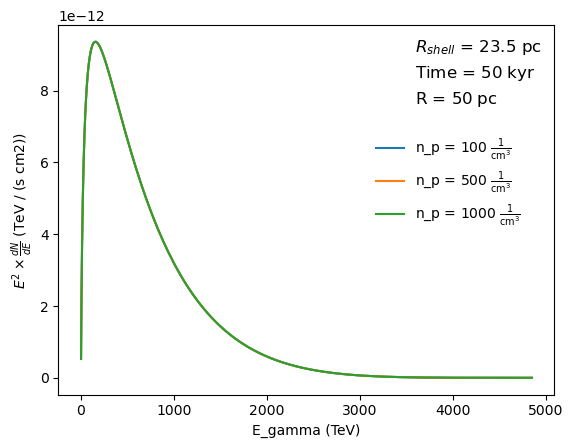

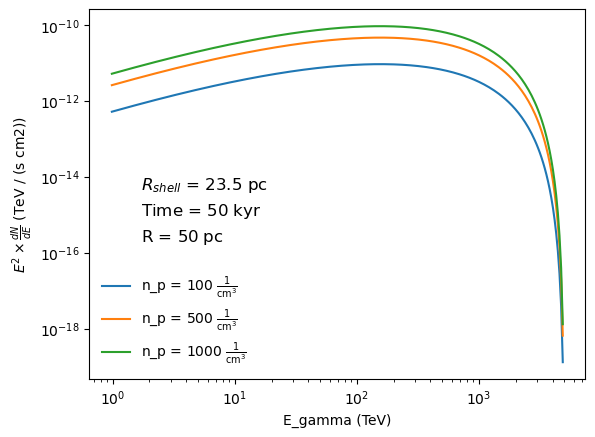

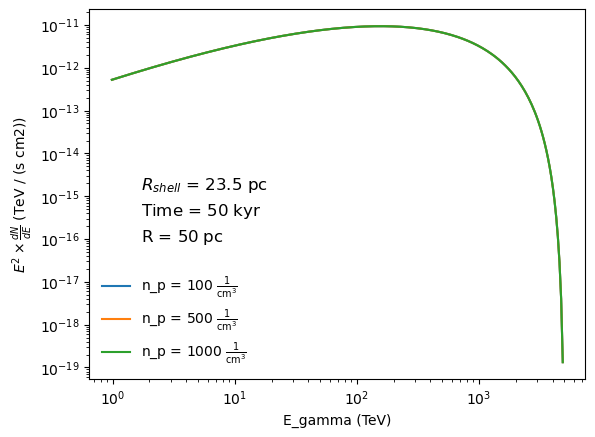

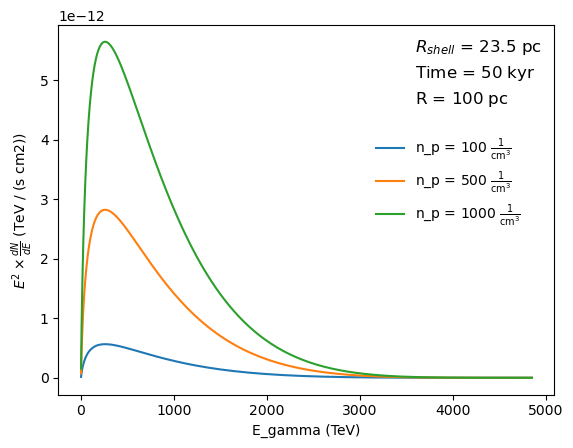

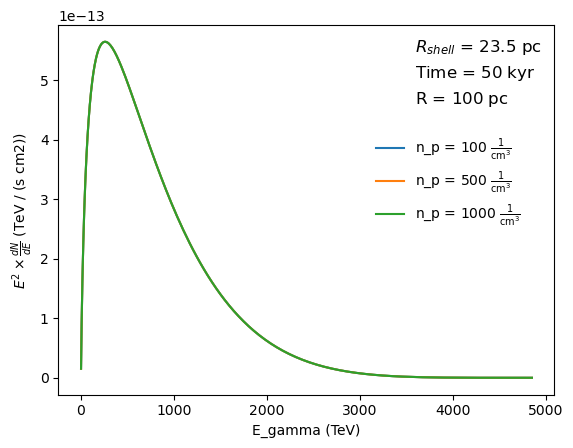

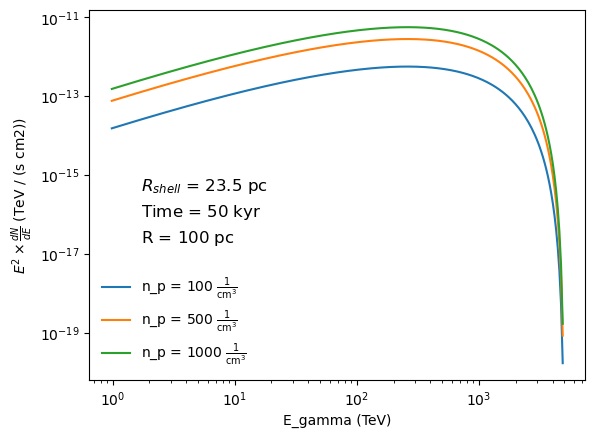

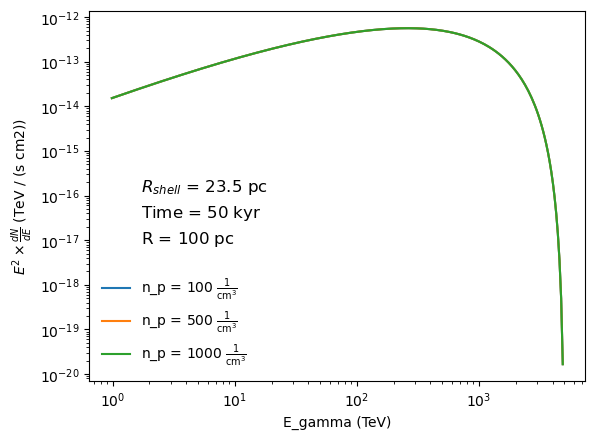

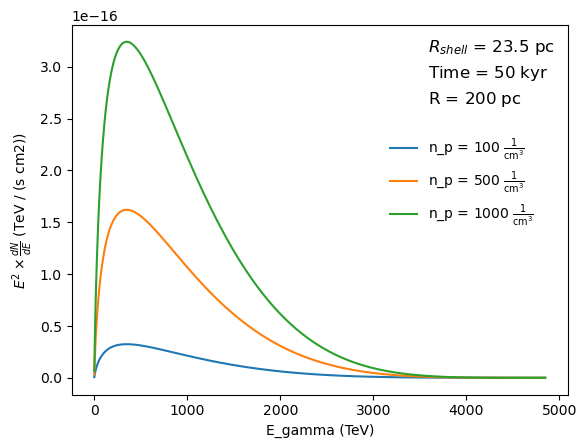

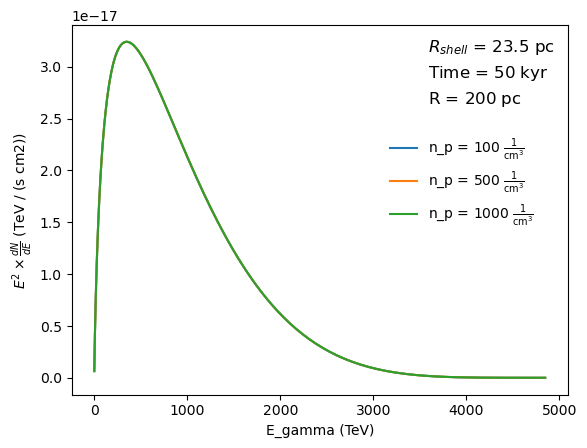

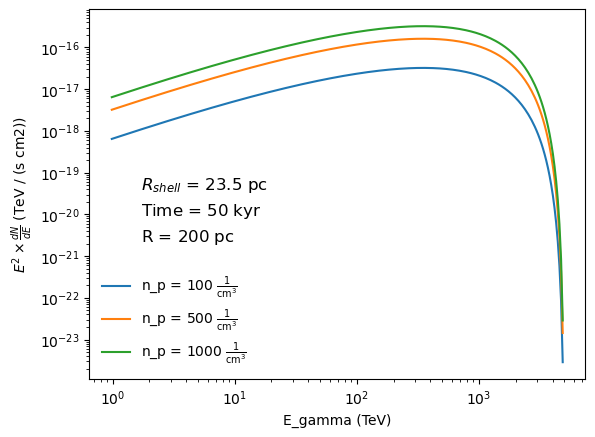

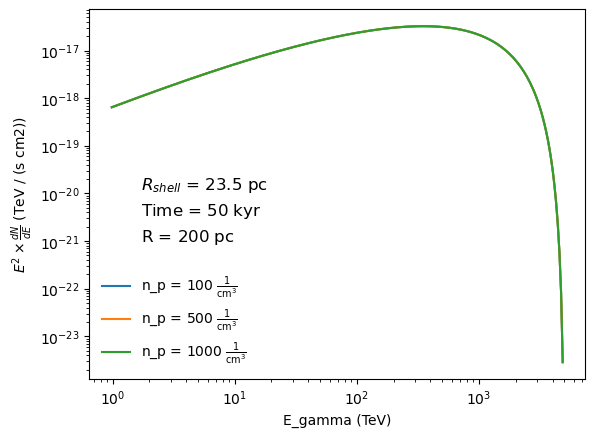

In [35]:
savePlots = True
plotParameterVariance(protonNumberDensityVarianceComputations, 'change_proton_number_density')

In [36]:
d_parameter_list = [1, 5, 10, 20] * u.kpc
args = {"parameter_name": "dist_to_earth", "parameter_symbol": "d", "parameter_list": d_parameter_list}

distToEarthVarianceComputations = []

distToEarthVarianceComputations.append(computeGammaProductionRateParameterVariance(4_000*u.yr, 20 * u.pc, **args))
distToEarthVarianceComputations.append(computeGammaProductionRateParameterVariance(20_000*u.yr, 20 * u.pc, **args))
distToEarthVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 20 * u.pc, **args))

distToEarthVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 50 * u.pc, **args))
distToEarthVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 100 * u.pc, **args))
distToEarthVarianceComputations.append(computeGammaProductionRateParameterVariance(50_000*u.yr, 200 * u.pc, **args))

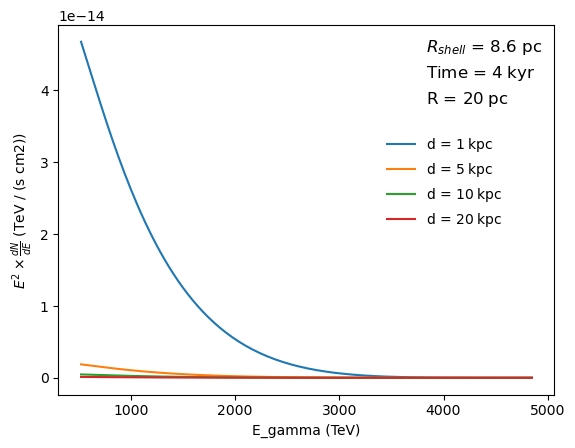

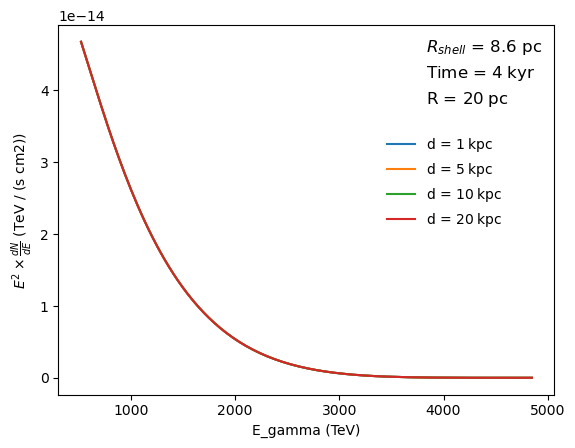

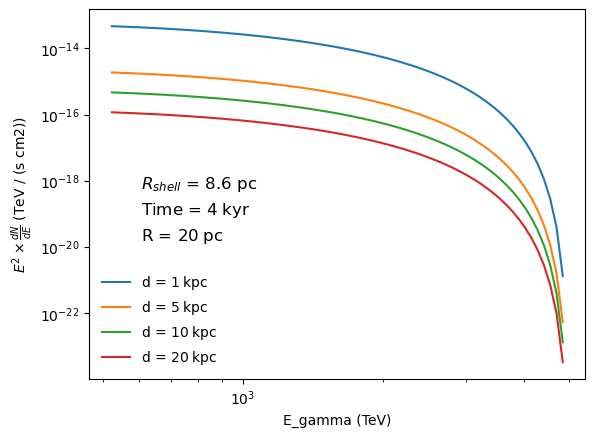

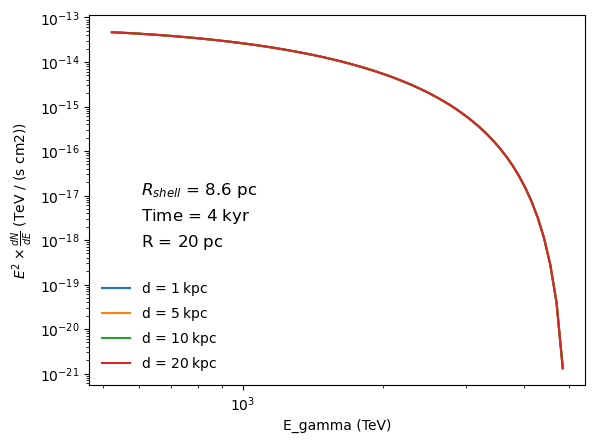

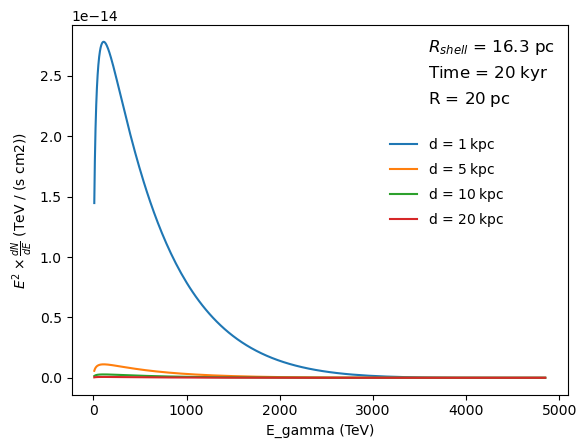

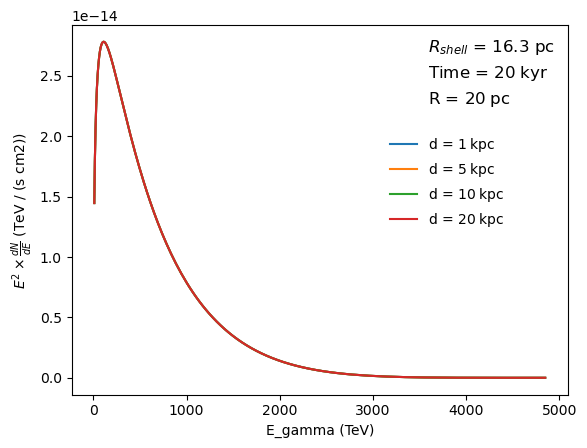

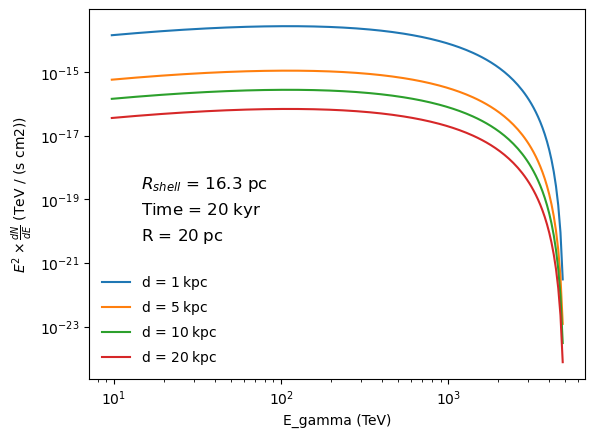

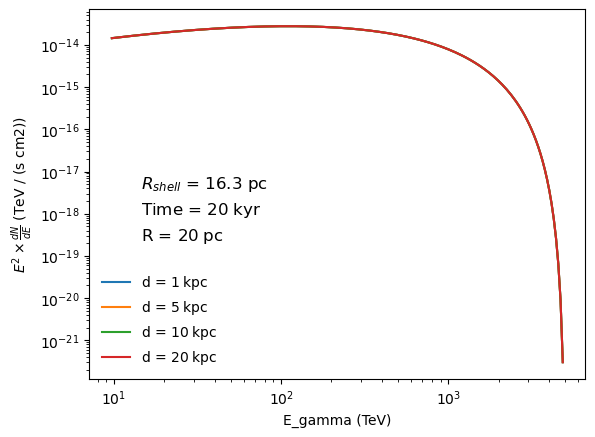

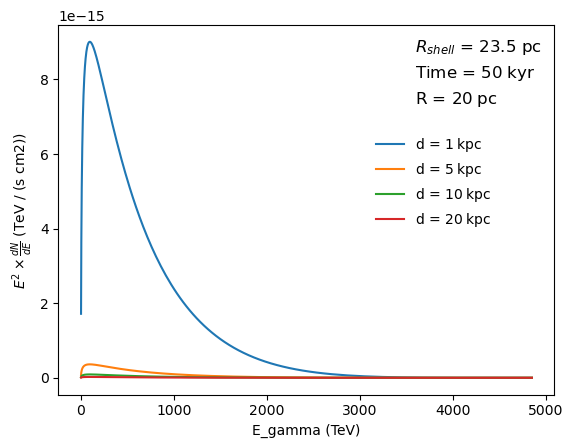

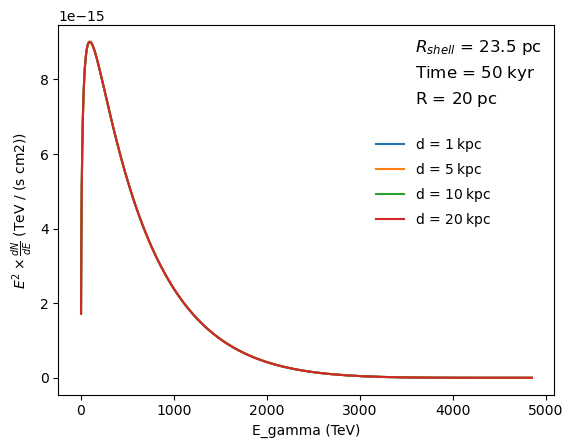

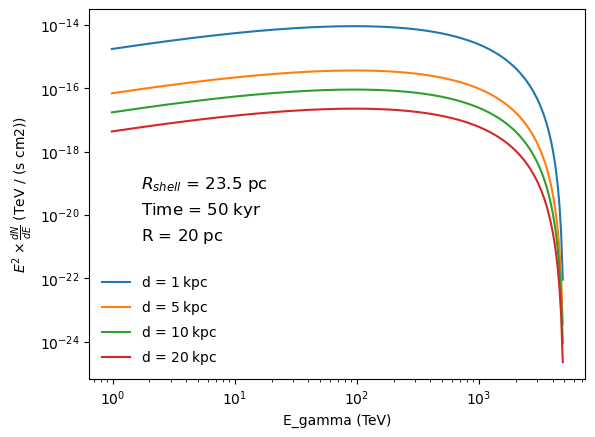

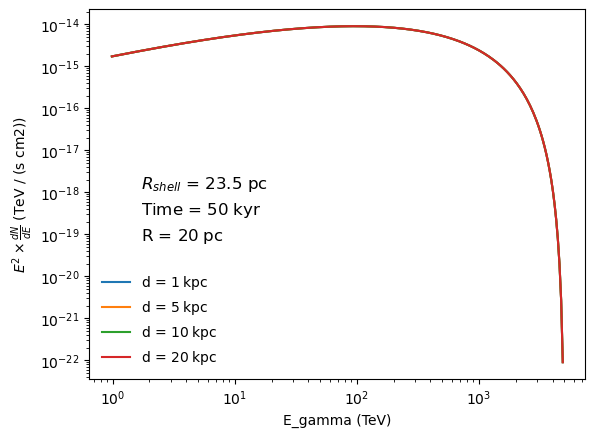

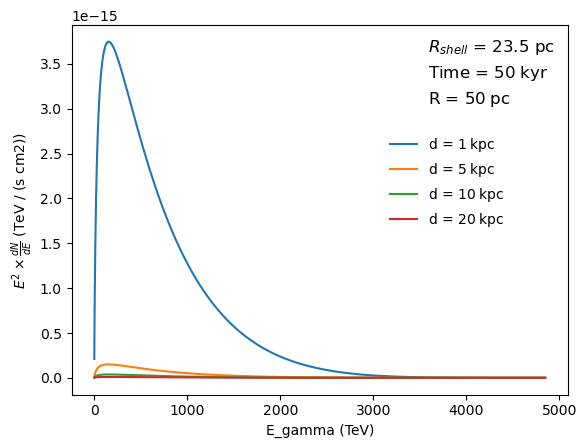

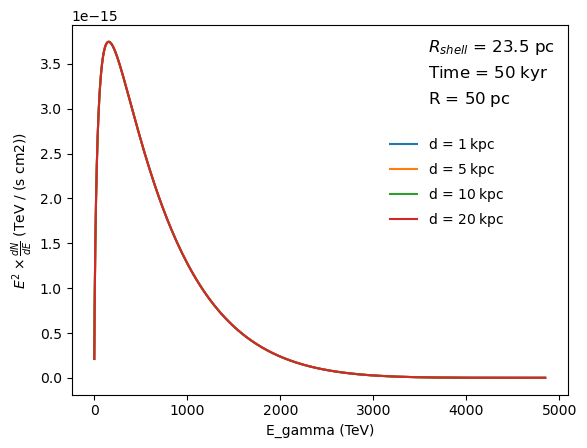

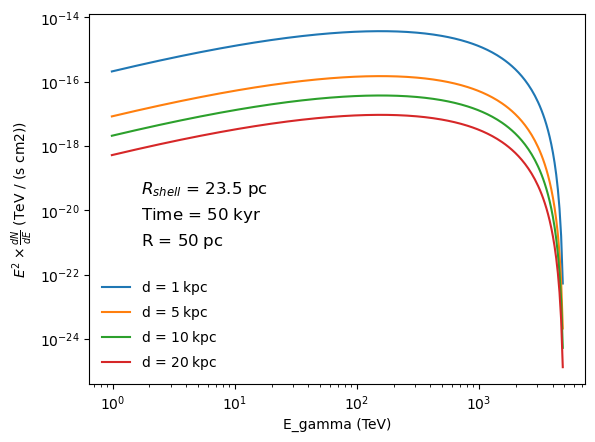

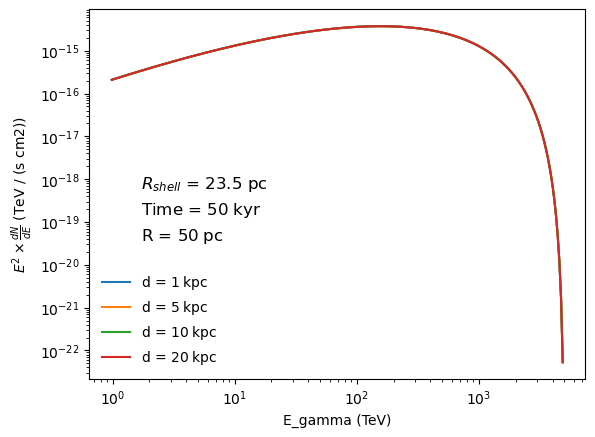

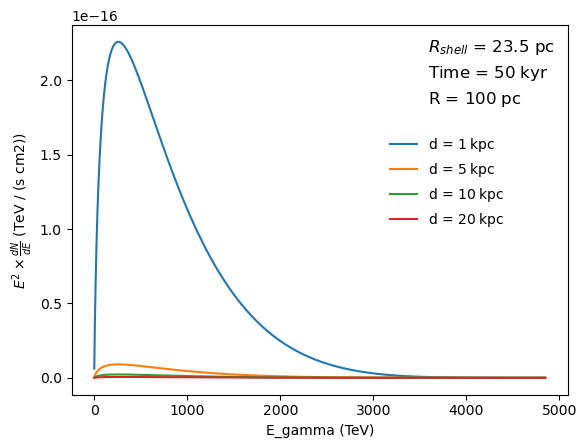

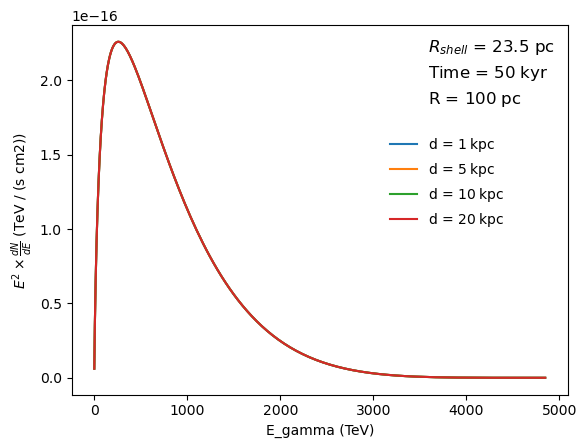

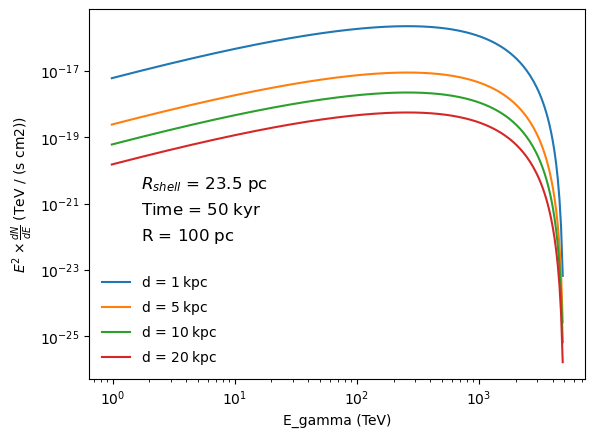

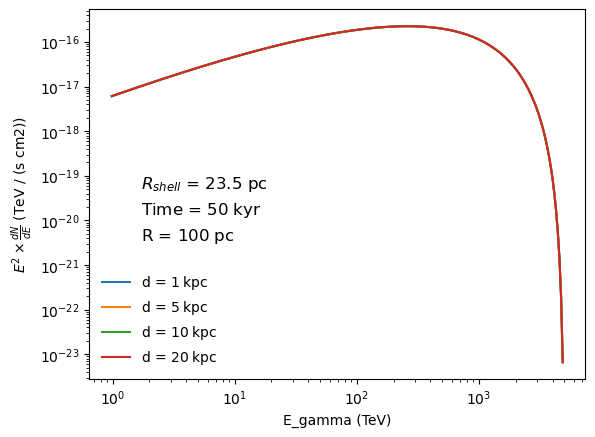

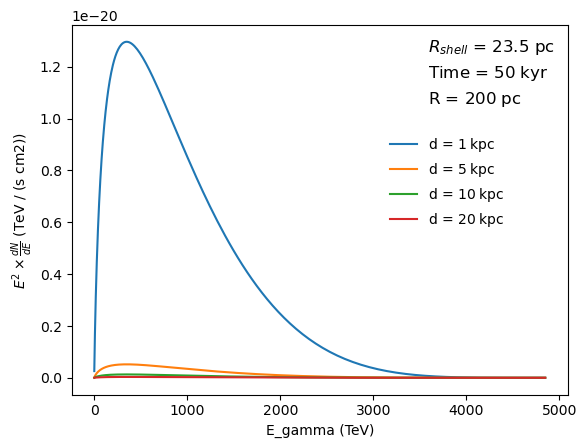

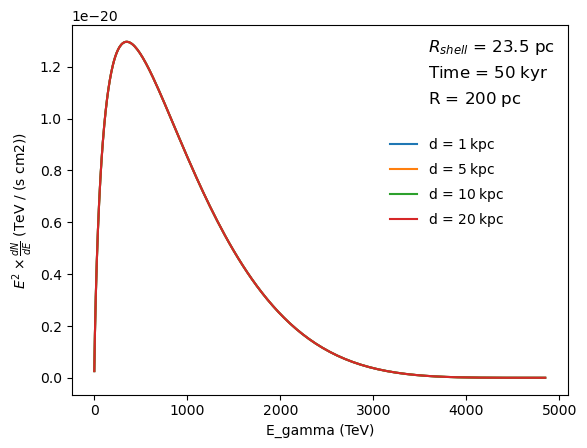

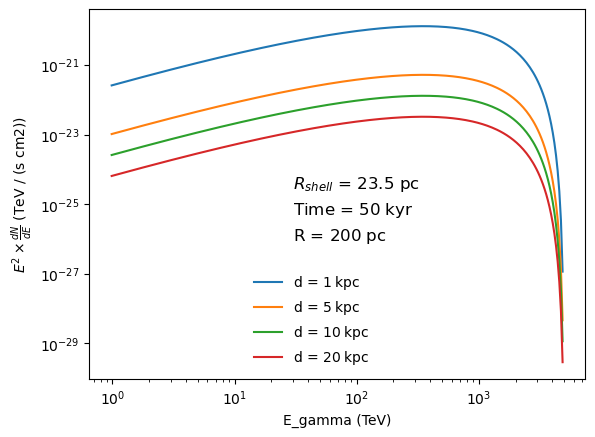

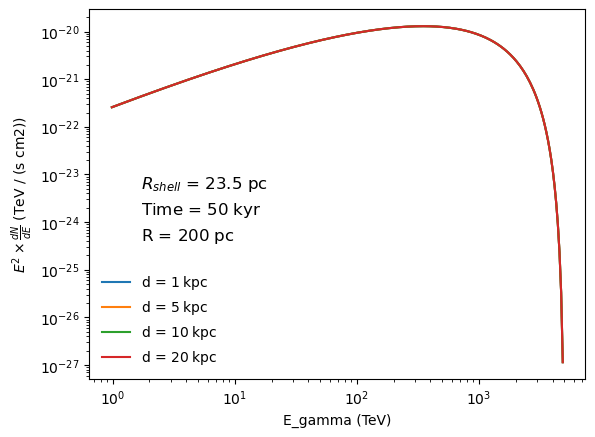

In [37]:
savePlots = True
plotParameterVariance(distToEarthVarianceComputations, 'change_dist_to_earth')